# Hồi quy đa biến Multiple Regression (Diễn giải)

Trong notebook này, chúng ta sẽ sử dụng dữ liệu doanh số bán nhà ở Quận King để dự đoán giá nhà sử dụng hồi quy tuyến tính đa biến. Chúng ta sẽ:
* Thực hiện một số thiết kế đặc trưng bằng các hàm DataFrame nội bộ.
* Sử dụng các hàm sklearn có sẵn để tính hồi quy và truy cập các tham số của nó (hệ số).
* Viết hàm tính RSS với các trọng số hồi quy, yếu tố dự báo và đầu ra đã cho.
* Xem các hệ số và diễn giải ý nghĩa của chúng.
* Đánh giá mô hình đa biến qua RSS.

## Import thư viện

In [1]:
import sklearn, pandas
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load dữ liệu bán nhà

Tập dữ liệu từ doanh số bán nhà quận King, Seatle, WA.

In [2]:
full_data = pandas.read_csv("house_data/kc_house_data.csv", index_col=0)

## Chia dữ liệu thành tập huấn luyện và kiểm tra.
Chúng ta sử dụng seed=0 để mọi người chạy notebook này có đều được kết quả tương tự. Thực tế, các bạn có thể thiết lập seed ngẫu nhiên để đảm bảo tính nhất quán. 

In [3]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(full_data, train_size=0.8, test_size=0.2, random_state=0)
train_data = train_data.copy() # Tại sao phải copy???
test_data = test_data.copy()

In [4]:
train_data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
5100402668,20150218T000000,495000.0,3,1.0,1570,5510,1.0,0,0,4,7,1070,500,1940,0,98115,47.6942,-122.319,1770,6380
7856560480,20140808T000000,635000.0,3,2.5,1780,11000,1.0,0,0,4,8,1210,570,1980,0,98006,47.5574,-122.149,2310,9700
2872900010,20150414T000000,382500.0,3,1.5,1090,9862,1.0,0,0,3,8,1090,0,1987,0,98074,47.6256,-122.036,1710,9862
3216900070,20140617T000000,382500.0,4,2.5,2210,7079,2.0,0,0,3,8,2210,0,1993,0,98031,47.4206,-122.183,1970,7000
976000790,20141020T000000,670000.0,3,2.5,1800,4763,2.0,0,0,3,7,1240,560,1985,0,98119,47.6460,-122.362,1790,4763


# Tìm hiểu mô hình hồi quy đa biến

Chúng ta có thể sử dụng code sau để tìm hiểu mô hình hồi quy đa biến dự đoán 'price' dựa trên các đặc trưng sau: example_features = ['sqft_living', 'bedrooms', 'bathrooms'] trong dữ liệu huấn luyện với code:

In [5]:
def extract_features(data, features_title):
    # nhận các đặc trưng từ DataFrame
    features = [data[title].values for title in features_title]
    # xếp chồng chúng thành 2d [examples, properties]
    return np.stack(features, axis=-1)

In [6]:
from sklearn.linear_model import LinearRegression

example_features_title = ['sqft_living', 'bedrooms', 'bathrooms']
# trích xuất đặc trưng thành các mảng numpy và xếp chồng chúng mỗi example 
example_features = extract_features(train_data, example_features_title)
example_labels = train_data['price']
example_model = LinearRegression().fit(example_features, example_labels)

In [7]:
type(example_features)

numpy.ndarray

Chúng ta đã khớp mô hình, giờ có thể trích xuất các trọng số mô hình (hệ số) từ mô hình như sau:

In [8]:
example_weight_summary = example_model.coef_
print(example_weight_summary)

[   313.17055038 -56754.66651422   6887.71910816]


## Đưa ra dự đoán

Trong notebook về gradient descent, chúng ta sử dụng numpy để thực hiện hồi quy. Trong notebook này, chúng ta sẽ sử dụng các hàm giao diện của mô hình sklearn hiện có để phân tích hồi quy đa biến.

Khi mô hình đã xây, chúng ta có thể sử dụng hàm `predict` để tìm các giá trị dự đoán cho dữ liệu mà chúng ta truyền vào. Ví dụ: sử dụng example_model trên: 

In [9]:
example_predictions = example_model.predict(example_features)
print(example_predictions[0]) # should be 395813.499

395813.4988028934


## Tính RSS

Bây giờ chúng ta có thể đưa ra các dự đoán cho mô hình, hãy viết một hàm tính RSS của mô hình. Hoàn thành hàm dưới đây để tính RSS với mô hình, dữ liệu và đầu ra đã biết.

In [10]:
def get_residual_sum_of_squares(model, data, outcome):
    # Trước tiên lấy các dự đoán
    predicted = model.predict(data)

    # Sau đó tính các phần dư/lỗi
    residuals = predicted - outcome

    # Bình phương lên và cộng tổng 
    RSS = np.sum(residuals ** 2)

    return(RSS)    

Kiểm tra hàm bằng cách tính RSS trong dữ liệu KIỂM TRA cho mô hình mẫu:

In [11]:
example_test_features = extract_features(test_data, example_features_title)
example_test_labels = test_data['price']
rss_example_test = get_residual_sum_of_squares(example_model, example_test_features, example_test_labels)
print(rss_example_test) # should be ~ 2.5921e+14

259213572106085.5


# Tạo một số đặc trưng mới

Chúng ta thường nghĩ hồi quy đa biến gồm nhiều đặc trưng khác nhau (ví dụ: số phòng ngủ, diện tích và số phòng tắm), nhưng chúng ta cũng có thể xem xét việc biến đổi các đối đặc trưng hiện có, ví dụ: log của squarefeet hoặc thậm chí các đặc trưng "tương tác" như tích của số phòng ngủ và số phòng tắm.

Giờ chúng ta sẽ sử dụng hàm logarit mặc định của python để tạo đặc trưng mới. Chúng ta cần import nó từ thư viện math.

In [12]:
from math import log

Tiếp theo, chúng ta sẽ tạo 4 đặc trưng mới sau làm cột trong cả dữ liệu HUẤN LUYỆN và KIỂM TRA:
* `bedrooms_squared = bedrooms\*bedrooms`
* `bed_bath_rooms = bedrooms\*bathrooms`
* `log_sqft_living = log(sqft_living)`
* `lat_plus_long = lat + long` 

Ví dụ như sau:

In [13]:
train_data['bedrooms_squared'] = train_data['bedrooms'].map(lambda x: x**2)
test_data['bedrooms_squared'] = test_data['bedrooms'].map(lambda x: x**2)

train_data['bed_bath_rooms'] = train_data['bedrooms'] * train_data['bathrooms']
test_data['bed_bath_rooms'] = test_data['bedrooms'] * test_data['bathrooms']

train_data['log_sqft_living'] = train_data['sqft_living'].map(lambda x: log(x))
test_data['log_sqft_living'] = test_data['sqft_living'].map(lambda x: log(x))

train_data['lat_plus_long'] = train_data['lat'] + train_data['long']
test_data['lat_plus_long'] = test_data['lat'] + test_data['long']

train_data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bedrooms_squared,bed_bath_rooms,log_sqft_living,lat_plus_long
id,,,,,,,,,,,,,,,,,,,,,
5100402668,20150218T000000,495000.0,3,1.0,1570,5510,1.0,0,0,4,...,0,98115,47.6942,-122.319,1770,6380,9,3.0,7.358831,-74.6248
7856560480,20140808T000000,635000.0,3,2.5,1780,11000,1.0,0,0,4,...,0,98006,47.5574,-122.149,2310,9700,9,7.5,7.484369,-74.5916
2872900010,20150414T000000,382500.0,3,1.5,1090,9862,1.0,0,0,3,...,0,98074,47.6256,-122.036,1710,9862,9,4.5,6.993933,-74.4104
3216900070,20140617T000000,382500.0,4,2.5,2210,7079,2.0,0,0,3,...,0,98031,47.4206,-122.183,1970,7000,16,10.0,7.700748,-74.7624
976000790,20141020T000000,670000.0,3,2.5,1800,4763,2.0,0,0,3,...,0,98119,47.6460,-122.362,1790,4763,9,7.5,7.495542,-74.7160


* `bedrooms*bedrooms` sẽ tăng phân tách giữa ít phòng ngủ (chẳng hạn: 1) và nhiều phòng ngủ (chẳng hạn: 4). Do đó, đặc trưng này phần lớn sẽ ảnh hưởng với nhiều phòng ngủ.
* `bedrooms*bathrooms` cho đặc trưng "tương tác", nó sẽ lớn khi cả hai đều lớn.
* `log(sqft_living)` khiến các giá trị lớn hơn gần nhau hơn và lan ra các giá trị nhỏ.
* `lat + long` hoàn toàn không có ý nghĩa nhưng chúng ta vẫn thực hiện (bạn sẽ biết lý do sau).

**Quiz: Giá trị trung bình cộng của 4 đặc trưng mới trong dữ liệu KIỂM TRA là bao nhiêu? (làm tròn tới 2 chữ số thập phân)**

In [14]:
# pandas.Series có hàm gọi chính xác như vậy.
test_data.iloc[:, -4:].mean().round(2)

bedrooms_squared    12.21
bed_bath_rooms       7.45
log_sqft_living      7.55
lat_plus_long      -74.65
dtype: float64

## Tìm hiểu mô hình đa biến

Bây giờ chúng ta sẽ tìm hiểu trọng số của ba mô hình (lồng nhau) dự đoán giá nhà. Mô hình đầu tiên sẽ ít đặc trưng nhất, mô hình thứ hai sẽ thêm một đặc trưng và mô hình thứ ba sẽ thêm vài đặc trưng khác:
* Mô hình 1: `sqft_living`, `#bedrooms`, `#bathrooms`, `lat & long`
* Mô hình 2: thêm `bedrooms*bathrooms`
* Mô hình 3: thêm `log_sqft`, `bedrooms_squared`, và `lat_plus_long`

In [15]:
model_1_features = ['sqft_living', 'bedrooms', 'bathrooms', 'lat', 'long']
model_2_features = model_1_features + ['bed_bath_rooms'] # Interaction terms
model_3_features = model_2_features + ['bedrooms_squared', 'log_sqft_living', 'lat_plus_long']

Bạn đã có các đặc trưng, trọng số cho 3 mô hình khác nhau dự đoán target = `'price'` sử dụng `LinearRegression` của `sklearn` và thấy giá trị trọng số/hệ số:

*Lưu ý: mô hình hồi quy trong khóa này thường có `coef_`*

In [16]:
# Tìm hiểu 3 mô hình. Trích xuất đặc trưng và khớp mô hình với các đặc trưng tương ứng. 
# Nếu không nhớ, hãy xem example_model bên trên

model1 = LinearRegression().fit(extract_features(train_data, model_1_features), train_data['price'])
model2 = LinearRegression().fit(extract_features(train_data, model_2_features), train_data['price'])
model3 = LinearRegression().fit(extract_features(train_data, model_3_features), train_data['price'])


In [17]:
# Kiểm tra/trích xuất từng hệ số của mô hình. Nếu nghi ngỡ, hãy tham khảo tài liệu của sklearn. 

# 'sqft_living', 'bedrooms', 'bathrooms', 'lat', 'long' , 'bed_bath_rooms', 'bedrooms_squared', 'log_sqft_living', 'lat_plus_long'
print("Model 1: - coef_:", model1.coef_)
print("Model 2: - coef_:", model2.coef_)  
print("Model 3: - coef_:", model3.coef_)

Model 1: - coef_: [ 3.12942010e+02 -5.30962691e+04  1.47770428e+04  6.53983343e+05
 -3.25707336e+05]
Model 2: - coef_: [ 3.06819573e+02 -1.04604718e+05 -7.01815289e+04  6.50590952e+05
 -3.09965751e+05  2.49441497e+04]
Model 3: - coef_: [ 5.37808085e+02  2.78047823e+03  1.01363764e+05  2.19151411e+12
  2.19151317e+12 -1.81822546e+04  7.24579893e+02 -5.71030020e+05
 -2.19151346e+12]


### Some Visualizations

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

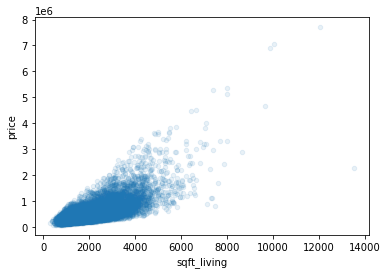

In [23]:
# Model: 1 'sqft_living', 'bedrooms', 'bathrooms', 'lat', 'long'
train_data.plot(x='sqft_living', y='price', kind='scatter', alpha=0.1)

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

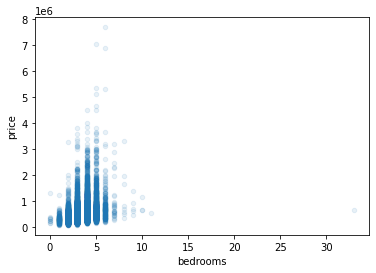

In [24]:
train_data.plot(x='bedrooms', y='price', kind='scatter', alpha=0.1)

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

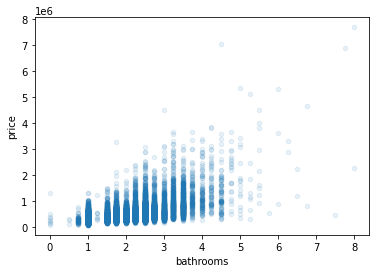

In [29]:
train_data.plot(x='bathrooms', y='price', kind='scatter', alpha=0.1)

<AxesSubplot:xlabel='bed_bath_rooms', ylabel='price'>

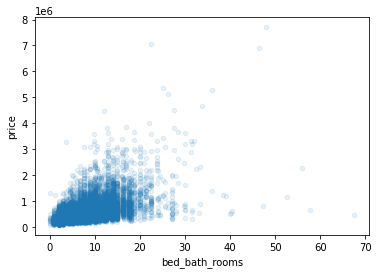

In [26]:
# Model 2 features =  model 1 features + ['bed_bath_rooms'] # bed_bath_rooms = ['bedrooms'] * ['bathrooms']
train_data.plot(x='bed_bath_rooms', y='price', kind='scatter', alpha=0.1)

<AxesSubplot:xlabel='bedrooms_squared', ylabel='price'>

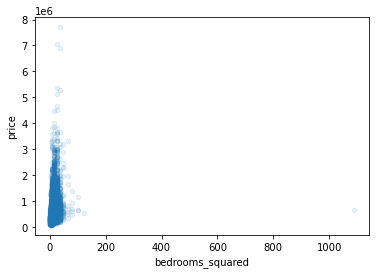

In [27]:
# Model 3 features =  model 2 features + ['bedrooms_squared', 'log_sqft_living', 'lat_plus_long']
train_data.plot(x='bedrooms_squared', y='price', kind='scatter', alpha=0.1)

<AxesSubplot:xlabel='log_sqft_living', ylabel='price'>

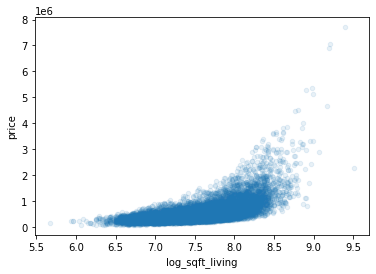

In [28]:
train_data.plot(x='log_sqft_living', y='price', kind='scatter', alpha=0.1)

**Quiz: Dấu (dương hoặc âm) của hệ số/trọng số cho 'bathrooms' trong mô hình 1 là gì?**

**Quiz: Dấu (dương hoặc âm) của hệ số/trọng số cho 'bathrooms' trong mô hình 2 là gì?**

Hãy nghĩ xem điều này có ý nghĩa gì.

## So sánh các mô hình đa biến

Chúng ta đã nghiên cứu 3 mô hình và trích xuất trong số mô hình mà chúng ta muốn đánh giá là tốt nhất.

Trước tiên sử dụng các hàm trước đó để tính RSS trong dữ liệu HUẤN LUYỆN cho từng mô hình.

In [18]:
# Tính RSS trong dữ liệu HUẤN LUYỆN cho từng mô hình và hiển thị các giá trị. 
# Xem lab trước nếu quên cách làm.


**Quiz: Mô hình nào (1, 2 hay 3) có RSSS thấp nhất trong dữ liệu HUẤN LUYỆN?** Đây có phải điều chúng ta dự kiến?

Bây giờ hãy tính RSS trong dữ liệu KIỂM TRA cho từng mô hình. 

In [19]:
# Tính RSS trong dữ liệu KIỂM TRA cho từng mô hình và hiển thị các giá trị.


**Quiz: Mô hình nào (1, 2 hay 3) có RSSS thấp nhất trong dữ liệu KIỂM TRA?** Đây có phải điều chúng ta dự kiến? Nghĩ về các đặc trưng đã thêm vào từng mô hình trước đó. 